# **Simple DNN for Text Classification**  

In this notebook, we will explore how to build and train a **Simple Deep Neural Network (DNN)** for text classification. Unlike RNNs or CNNs, a DNN consists of fully connected **dense layers**, making it a straightforward yet powerful approach for classification tasks.  

A **DNN** is **faster to train** than RNNs because it processes input **in parallel** instead of sequentially. When combined with pretrained embeddings or good text representations, it can efficiently learn patterns for multi-class text classification.  

### **Objective:**  
- **Build** a Simple DNN model for text classification.  
- **Train** and **evaluate** the model on a labeled dataset.  
- **Tune** hyperparameters to optimize model performance.  
- **Save** the trained model for future use.  

Since the **text data preprocessing** (tokenization, padding, and encoding) has already been completed in the previous notebook, we will import the preprocessed data and proceed directly to model construction, training, evaluation, and saving.  

### **Steps:**  
1. **Import Required Libraries and Setup**: Load the necessary libraries and set up project paths and configurations.  
2. **Import Preprocessed Data**: Load the tokenized and padded text data from the previous notebook.  
3. **Model Construction**: Define an initial **fully connected DNN architecture** as a baseline model.  
4. **Training the Model**: Train the model using the prepared dataset.  
5. **Evaluation**: Perform a **customized performance analysis** to assess the model's effectiveness on test data.  
6. **Hyperparameter Tuning**: Given computational constraints, we focus on optimizing only the most relevant parameters.  
7. **Save Models**: Save both the **initial trained DNN model** and the **best optimized model** for future use.  


## 1. Import Required Libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import os
import json
import pandas as pd
import numpy as np
import pickle

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, layers, backend as K
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, RNN, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping


# Machine Learning & Model Evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scikeras.wrappers import KerasClassifier


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

from pathlib import Path
import importlib
import itertools
from datetime import datetime


### Setting Up Project Paths and Configurations

In [2]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 level)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py
importlib.reload(config)  # Reload config to ensure any updates are applied

Project Root Directory: Data_Scientist_Rakuten_Project-main


<module 'config' from 'D:\\Data_Science\\Append_Data_Engineer_AWS_MLOPS\\Data_Scientist_Rakuten_Project-main\\config.py'>

## 2. Import Preprocessed Data

In this step, we will import the preprocessed data that has already been tokenized and padded, with the original training dataset split into training and testing sets using `train_test_split`. The data we are importing includes:


- **X_train_split_tokenized**: The training data that has been tokenized, padded, and split from the original dataset.
- **X_test_split_tokenized**: The testing data that has been tokenized, padded, and split from the original dataset.
- **y_train_split**: The corresponding target labels for the training data, also split after applying `train_test_split`.
- **y_test_split**: The corresponding target labels for the testing data, after splitting.


In [3]:
# Define paths for datasets
xtrain_tokenized_path = Path(config.X_TRAIN_SPLIT_TOKENIZED_PATH)
xtest_tokenized_path = Path(config.X_TEST_SPLIT_TOKENIZED_PATH)
y_train_split_path = Path(config.Y_TRAIN_SPLIT_PATH)
y_test_split_path = Path(config.Y_TEST_SPLIT_PATH)


#  Load tokenizer
tokenizer_path = Path(config.TOKENIZER_PATH)
                    
# Function to get relative paths from project root
def get_relative_path(absolute_path: Path):
    """Returns the relative path from the project root."""
    return str(absolute_path.relative_to(config.BASE_DIR))

# Function to load a Pickle file safely
def load_pickle(file_path: Path, dataset_name: str):
    """Loads a pickle file with error handling and basic visualization."""
    if not file_path.exists():
        print(f"Error: `{dataset_name}` file not found at {file_path}")
        return None

    try:
        data = pd.read_pickle(file_path)
        print(f"Successfully loaded `{dataset_name}` | Shape: {data.shape}")
        
#         # Display first rows if dataset is not empty
#         if not data.empty:
#             display(data.head())

        return data
    except Exception as e:
        print(f"Error loading `{dataset_name}`: {e}")
        return None

        return None, None

def load_tokenizer(tokenizer_path: Path):
    """Loads the saved tokenizer and determines the correct vocabulary size."""
    if not tokenizer_path.exists():
        print(f"Error: `Tokenizer` not found at {tokenizer_path}")
        return None, None

    try:
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Check if num_words was set during training
        if tokenizer.num_words is not None:
            vocab_size = tokenizer.num_words  # Use the predefined vocabulary limit
        else:
            vocab_size = len(tokenizer.word_index) + 1  # Otherwise, use the full vocabulary

        # Print vocabulary details separately
        print(f"Tokenizer successfully loaded.")
        print(f"Vocabulary size used (vocab_size): {vocab_size}")
        print(f"Total words found in dataset: {len(tokenizer.word_index)}")

        return tokenizer, vocab_size
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return None, None


    
# List of required files with their names
required_files = {
    "Tokenized Training Dataset": xtrain_tokenized_path,
    "Tokenized Testing Dataset": xtest_tokenized_path,
    "Training Labels": y_train_split_path,
    "Testing Labels": y_test_split_path,
    "Tokenizer": tokenizer_path  
}

# Check if files exist before loading
for name, path in required_files.items():
    if not path.exists():
        raise FileNotFoundError(f"Error: `{name}` file not found at {get_relative_path(path)}")

# Load datasets
X_train = load_pickle(xtrain_tokenized_path, "X_train_TokenizationSequencing.pkl")
X_test = load_pickle(xtest_tokenized_path, "X_test_TokenizationSequencing.pkl") # Submission dataset
y_train = load_pickle(y_train_split_path, "y_train_split.pkl")
y_test = load_pickle(y_test_split_path, "y_test_split.pkl")

# Load tokenizer
tokenizer, vocab_size = load_tokenizer(tokenizer_path)


Successfully loaded `X_train_TokenizationSequencing.pkl` | Shape: (67932, 500)
Successfully loaded `X_test_TokenizationSequencing.pkl` | Shape: (16984, 500)
Successfully loaded `y_train_split.pkl` | Shape: (67932,)
Successfully loaded `y_test_split.pkl` | Shape: (16984,)
Tokenizer successfully loaded.
Vocabulary size used (vocab_size): 20000
Total words found in dataset: 124636


## 3. Simple Deep Neural Network (DNN) Model Construction  

In this step, we construct a **Simple DNN model** for text classification. Unlike RNNs or Conv1D models, a **DNN relies only on fully connected layers**, making it a straightforward yet effective approach.  

### **Model Architecture:**  
- **Embedding Layer**: Transforms words into dense vector representations.  
- **Flatten Layer**: Converts the 2D embedding matrix into a 1D feature vector.  
- **Dense Layer (100 units, ReLU activation)**: Learns high-level representations from the text data.  
- **Dropout Layer (0.5)**: Prevents overfitting by randomly deactivating neurons.  
- **Dense Output Layer**: Uses **softmax activation** to classify text into one of **27 categories**.  


In [4]:
# Define embedding dimension
embedding_dim = 100
# Compute the maximum sequence length in X_train
maxlen = max(len(seq) for seq in X_train)
print(f"Dynamic maxlen set to: {maxlen}")


model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(27, activation='softmax'))

model.summary()

Dynamic maxlen set to: 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          2000000   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 100)               5000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                2727      
                                                                 
Total params: 7,002,827
Trainable params: 7,002,827
Non-trainable params: 0
_________________________________________________________________


## 4. Model Compilation, Training, and Evaluation

Before fine-tuning, we start with a **initial version** of our **Simple Deep Neural Network (DNN)** for multi-class text classification. This helps establish a **baseline** while **keeping training time and computational cost manageable**.  

### Model Parameters 

**Number of Epochs**: `EPOCHS = 50`  
- The model is trained for **up to 50 epochs**, but **early stopping** is applied to stop training when validation loss stops improving.  
- This ensures **optimal stopping** without overfitting.  

**Early Stopping Parameter**:  
- **`monitor='val_loss'`** → Tracks validation loss to determine when to stop training.  
- **`patience=3`** → Training stops if validation loss does not improve for 3 consecutive epochs.  
- **`restore_best_weights=True`** → Restores the model weights from the epoch with the lowest validation loss.  
 
**Batch Size**: `BATCH_SIZE = 200`  
- A batch size of `200` balances **memory usage and convergence speed**.  
- Since **text sequences** can be long, using a **moderate batch size** prevents excessive **GPU/CPU memory consumption**.  
**Loss Function**: `sparse_categorical_crossentropy`  
- Best suited for **multi-class classification** with integer-labeled categories.  

**Optimizer**: `Adam (learning_rate=0.001)`  
- **Adam** (Adaptive Moment Estimation) is used because **it adjusts the learning rate automatically and helps the model learn faster and more efficiently**.
- We set `learning_rate=0.001`, which is the **default value**, but this can be fine-tuned later.  

**Metrics**: `accuracy` (excluding `weighted_f1` from `metrics`)  
- `accuracy` is a **quick and interpretable metric** for an initial evaluation.  
- If the **custom `weighted_f1` function does not work correctly**, we will compute the **Weighted F1-score manually** after evaluation to ensure accurate results.  



### 4.1 Custom Function for Weighted F1-Score

In [ ]:
# from sklearn.metrics import f1_score
# import tensorflow as tf
# from tensorflow.keras import backend as K

# # Custom function to calculate weighted F1 score
# def weighted_f1(y_true, y_pred):
#     # Convert predictions to binary format (0 or 1)
#     y_true = tf.argmax(y_true, axis=-1)
#     y_pred = tf.argmax(y_pred, axis=-1)
    
#     # Convert tensors to numpy arrays for calculation
#     y_true = y_true.numpy()  # This will work if eager execution is enabled
#     y_pred = y_pred.numpy()
    
#     # Compute the weighted F1 score using sklearn's f1_score
#     return f1_score(y_true, y_pred, average='weighted')


### 4.2 Model Compilation and Training

In [5]:
%%time

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore model weights from the best epoch
)


# Compile the model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Set learning rate explicitly
    loss='sparse_categorical_crossentropy',  # For integer-labeled data
     metrics=['accuracy'] ## Only accuracy is included; weighted F1 will be computed manually
#    metrics=['accuracy', weighted_f1]  # Include both accuracy and weighted F1-score : ISSUE HERE
)

# Define training parameters as variables
BATCH_SIZE = 200
EPOCHS = 50

# Train the model using the defined variables
history = model.fit(          
    X_train, 
    y_train.values, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_test, y_test.values),
    callbacks=[early_stopping]  # Include Early Stopping to prevent overfitting
)


Epoch 1/50
340/340 [==============================] - 4s 7ms/step - loss: 2.2844 - accuracy: 0.3385 - val_loss: 1.1134 - val_accuracy: 0.7037
Epoch 2/50
340/340 [==============================] - 2s 6ms/step - loss: 0.9055 - accuracy: 0.7392 - val_loss: 0.7163 - val_accuracy: 0.7911
Epoch 3/50
340/340 [==============================] - 2s 5ms/step - loss: 0.5595 - accuracy: 0.8381 - val_loss: 0.6642 - val_accuracy: 0.8052
Epoch 4/50
340/340 [==============================] - 2s 5ms/step - loss: 0.3998 - accuracy: 0.8856 - val_loss: 0.6829 - val_accuracy: 0.8088
Epoch 5/50
340/340 [==============================] - 2s 5ms/step - loss: 0.2978 - accuracy: 0.9164 - val_loss: 0.7013 - val_accuracy: 0.8126
Epoch 6/50
340/340 [==============================] - 2s 5ms/step - loss: 0.2271 - accuracy: 0.9366 - val_loss: 0.7713 - val_accuracy: 0.8083
Wall time: 13 s


### 4.3 Learning Curve Analysis

#### 4.3.1 Display the Learning Curves

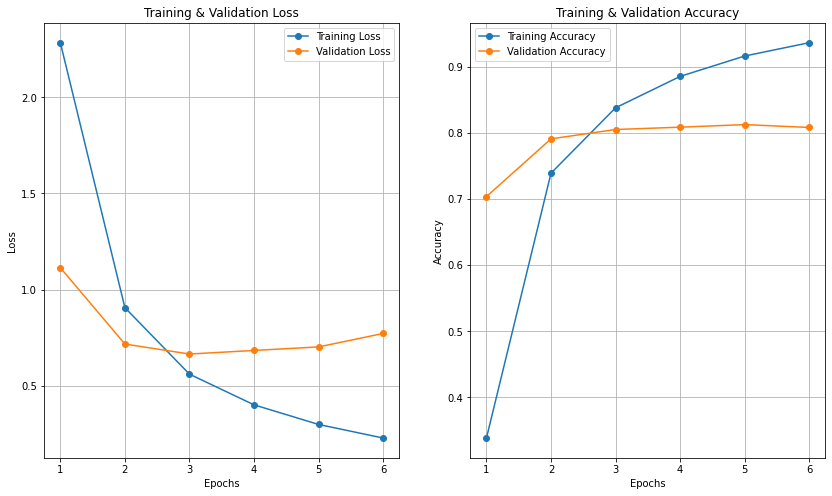

In [6]:
def plot_learning_curves(history):
    """
    Plots training & validation loss and accuracy over epochs.
    
    Args:
        history: Can be either:
            - A Keras `History` object (from model.fit())
            - A reloaded dictionary (from a JSON file)
    """

    # Check if `history` is a Keras History object
    if isinstance(history, tf.keras.callbacks.History):
        history_data = history.history  # Extract dictionary
    elif isinstance(history, dict):
        history_data = history  # Already a dictionary
    else:
        print("[X] Invalid `history` format. Expected a Keras History object or a dictionary.")
        return

    # Extract values
    epochs = range(1, len(history_data['loss']) + 1)
    train_loss = history_data['loss']
    val_loss = history_data['val_loss']
    train_acc = history_data['accuracy']
    val_acc = history_data['val_accuracy']

    # Plot Loss Curve
    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage after training
plot_learning_curves(history)  # Works with a Keras History object



####  4.3.2 Interpretation of Learning Curves

#### **1 Training & Validation Loss**  
- **Training loss decreases steadily** (model is learning).  
- **Validation loss stops improving after epoch ~3 and increases slightly after epoch 4** → **Overfitting starts**.  

 **Potential Solutions:**
- Use **early stopping (`patience=2`)** to stop training sooner (**optimal: ~3–4 epochs**).  
- Increase **dropout or L2 regularization** to improve generalization.  
- Experiment with **data augmentation** if applicable.  

---

#### **2 Training & Validation Accuracy**  
- **Training accuracy reaches ~94%, while validation accuracy stabilizes at ~82%** → **Overfitting confirmed**.  
- **The accuracy gap widens after epoch 3–4**, suggesting the model is memorizing training data.  

 **Potential Solutions:**
- Stop training earlier (**around epoch 3–4**) to prevent overfitting.  
- Reduce **model complexity** (e.g., fewer units in GRU/LSTM layers).  
- Apply **batch normalization or dropout tuning** for better regularization.  


### 4.4 Saving the Trained Model and Training History  

In [7]:
importlib.reload(config)  # Reload config to ensure any updates are applied
from datetime import datetime  # Import datetime for timestamp

# Define model name prefix (Change this for different architectures)
MODEL_NAME = "simple_dnn_model"  # Example: "gru_model", "lstm_model", etc.

# Ensure the directory exists before saving the model
os.makedirs(config.NEURAL_MODELS_DIR, exist_ok=True)

# Get current date and time in YYYYMMDD-HHMM format
timestamp = datetime.now().strftime("%Y%m%d-%H%M")

# Retrieve the number of epochs completed
if 'history' in globals():
     if isinstance(history, tf.keras.callbacks.History):
        num_epochs = len(history.epoch)  # Actual trained epochs
else:
    num_epochs = "unknown"

# Define a compact filename with model name, epochs, and timestamp
model_filename = f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}.h5"
history_filename =f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}_history.json"
# history_filename = f"{MODEL_NAME}_history_{timestamp}.json"

# Full paths for saving
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_filename)
history_path = os.path.join(config.NEURAL_MODELS_DIR, history_filename)

# Print save paths
print(f"Saving the model to: {model_path}")
print(f"Saving training history to: {history_path}")

try:
    # Save the trained Keras model
    model.save(model_path)
    print(f"[✔] Model saved successfully as {model_filename}")

    # Save training history (if available)
    if 'history' in globals():
        with open(history_path, "w") as f:
            json.dump(history.history, f)
        print(f"[✔] Training history saved successfully as {history_filename}")
    else:
        print("/!\ No training history found. Skipping history save.")

except Exception as e:
    print(f"X Error occurred while saving the model or history: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\simple_dnn_model_E50-T6_20250225-1519.h5
Saving training history to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\simple_dnn_model_E50-T6_20250225-1519_history.json
[✔] Model saved successfully as simple_dnn_model_E50-T6_20250225-1519.h5
[✔] Training history saved successfully as simple_dnn_model_E50-T6_20250225-1519_history.json


### 4.5 Loading the Trained Model and Training History (Optional)

In [7]:
importlib.reload(config) #  Reload config to apply any updates

# Ask the user for the model name to load
model_name = "simple_dnn_model_E50-T7_20250224-2320.h5"  # Change this to the desired model filename

# Define the full path to the model
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_name)

# Automatically derive the history filename from the model name
history_name = model_name.replace(".h5", "_history.json")  
history_path = os.path.join(config.NEURAL_MODELS_DIR, history_name)

# Load the model if the file exists
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f"✔ Model loaded successfully from: {model_path}")
else:
    print(f"[X] Model file not found at: {model_path}")
    model = None  # Avoid errors if model is missing

# Load the training history if the file exists
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    print(f"✔ Training history loaded successfully from: {history_path}")
else:
    print(f"[X] Training history file not found at: {history_path}")
    history = None  # Avoid errors if history is missing

✔ Model loaded successfully from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\simple_dnn_model_E50-T7_20250224-2320.h5


### 4.6 Model Evaluation on the Test Set

531/531 [==============================] - 2s 3ms/step - loss: 0.6642 - accuracy: 0.8052
[✔] Test Loss: 0.6642
[✔] Test Accuracy: 0.8052
531/531 [==============================] - 1s 882us/step
[✔] Test Weighted F1-Score (computed manually): 0.8073

[✔] Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.60      0.47       643
           1       0.71      0.74      0.72       911
           2       0.80      0.79      0.80       319
           3       0.72      0.72      0.72      1002
           4       0.89      0.61      0.72       557
           5       0.93      0.92      0.93      1011
           6       0.79      0.68      0.73       533
           7       0.81      0.84      0.83       993
           8       0.64      0.50      0.56       408
           9       0.89      0.93      0.91       832
          10       0.72      0.76      0.74       961
          11       0.77      0.79      0.78       545
          12       0

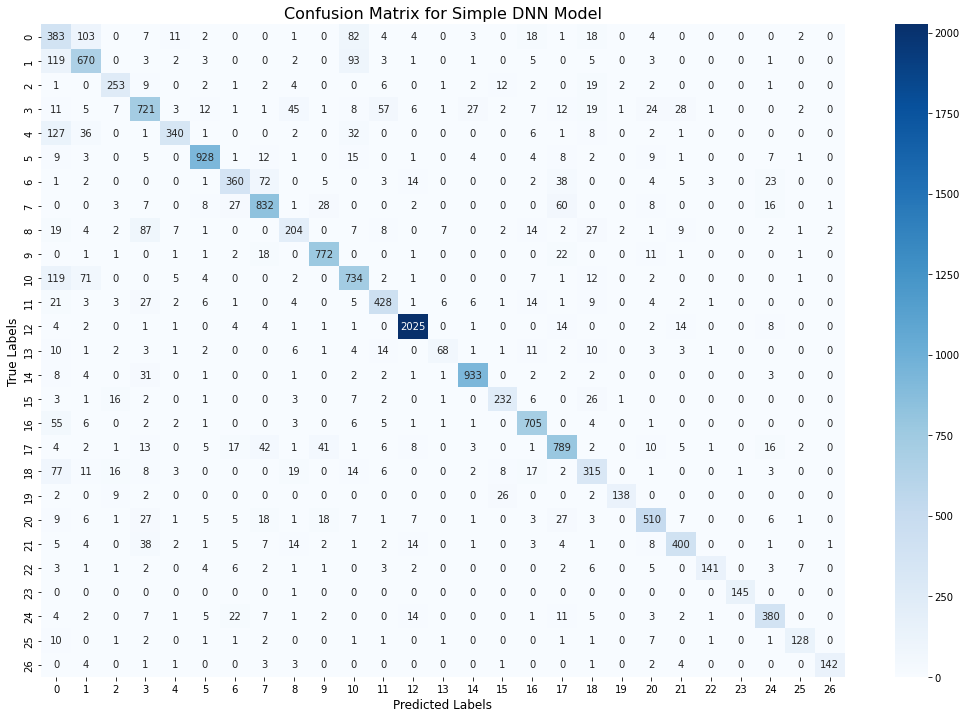

Wall time: 4.27 s


In [8]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test.values)

# Print evaluation results
print(f"[✔] Test Loss: {test_loss:.4f}")
print(f"[✔] Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)

# Compute weighted F1-score manually
test_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
print(f"[✔] Test Weighted F1-Score (computed manually): {test_f1:.4f}")

# Print classification report
print("\n[✔] Classification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=0))

# Compute confusion matrix
conf_matrix_df_raw = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix_df_raw, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(27), yticklabels=np.arange(27))

# 6. Add titles and labels
plt.title('Confusion Matrix for Simple DNN Model', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Show the plot
plt.show()


## 5. Customized Model Performance Analysis

This section outlines our comprehensive evaluation of the model’s classification performance, structured as follows:

- **5.1 Customized Classification Report:**  
  We start by mapping the training class numbers to the original class numbers and labels, providing clarity on performance metrics across the original categories.

- **5.2 Classification Report Generation & Class Categorization:**  
  Here, we categorize classes based on their F1-scores using thresholds derived from the Rakuten benchmark (weighted F1-score = 0.8113). This approach helps us distinguish classes that are well-classified, moderately classified, or poorly classified, thereby pinpointing areas for targeted improvement.

- **5.3 Consolidated Misclassification Report:**  
  We then dive deeper into prediction errors with a multi-layered analysis that includes:  
  - **5.3.1 Confusion Matrix Visualization with Mapped Labels:** Visualizing misclassification patterns by aligning training class numbers with the original labels.  
  - **5.3.2 Breakdown of Misclassifications:** Identifying common misclassification trends and frequently confused classes.
  - **5.3.3 Detailed Misclassification Statistics:** Providing error counts and misclassification rates to highlight areas where the model underperforms.

This structured approach allows us to quickly identify strengths and focus on specific areas for improvement.


###  5.1 Customized Classification Report with Mapped Classes and Original Labels

In [9]:
import importlib
import src.model_evaluation  # Initial import
importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module

from src.model_evaluation import process_classification_report
# import config

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)

# Display accuracy separately
print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# Display final classification summary
print("\n[✔] Classification Summary Rows")
display(summary_rows)

# Display processed classification report
print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
display(classification_df.tail(27))





[✔] Accuracy: 0.81 (on 16984 samples)


[✔] Classification Summary Rows


,Metric Type,precision,recall,f1-score,support
28,macro avg,0.82,0.77,0.79,16984
29,weighted avg,0.82,0.81,0.81,16984



[✔] Processed Classification Report with Mapped Classes and Original Labels


,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support
0,0,10,Adult Books,0.38,0.60,0.47,643
1,1,2280,Magazines,0.71,0.74,0.72,911
2,2,50,Video Games Accessories,0.80,0.79,0.80,319
3,3,1280,Toys for Children,0.72,0.72,0.72,1002
4,4,2705,Books,0.89,0.61,0.72,557
5,5,2522,Stationery,0.93,0.92,0.93,1011
6,6,2582,"Furniture, Kitchen, and Garden",0.79,0.68,0.73,533
7,7,1560,Interior Furniture and Bedding,0.81,0.84,0.83,993
8,8,1281,Board Games,0.64,0.50,0.56,408
9,9,1920,Interior Accessories,0.89,0.93,0.91,832


### 5.2 Generating a Customized Classification Report & Categorizing Classes

To assess performance, classes are categorized based on their **F1-scores** using thresholds defined relative to the **Rakuten benchmark** (RNN on text data, weighted F1-score = **0.8113**). These thresholds are designed to pinpoint areas for improvement and align with industry standards:

- **Well-classified:** **F1 ≥ Benchmark (e.g., 0.80)** – Categories that perform on par with or better than the reference model.
- **Moderately classified:** **Threshold_lower ≤ F1 < Benchmark** – Categories that may require further refinement.
- **Poorly classified:** **F1 < Threshold_lower** – Categories with notable misclassification issues.

These thresholds are **customizable** and will be adjusted based on results from baseline models in this challenge.


In [10]:
import importlib
import src.model_evaluation  # Initial import
import src.display # Initial import

importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module
importlib.reload(src.display)  # Force reload the module
from src.model_evaluation import analyze_classification_performance, process_classification_report
from src.display import display_dataframe_to_user  # Import de la fonction

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Define classification thresholds
WELL_CLASSIFIED_THRESHOLD = 0.80
MODERATELY_CLASSIFIED_THRESHOLD = 0.50

# Run classification performance analysis with dynamic thresholds
category_counts, well_classified, moderately_classified, poorly_classified = analyze_classification_performance(
    classification_df, 
    well_classified_threshold=WELL_CLASSIFIED_THRESHOLD, 
    moderately_classified_threshold=MODERATELY_CLASSIFIED_THRESHOLD
)

# Display summary based on dynamic thresholds
print("\n[✔] Summary of Classification Performance:")
print(f"- {category_counts.get('Well-classified', 0)} classes have an F1-score ≥ {WELL_CLASSIFIED_THRESHOLD:.2f} (Well-classified)")
print(f"- {category_counts.get('Moderate', 0)} classes have an F1-score between {MODERATELY_CLASSIFIED_THRESHOLD:.2f} and {WELL_CLASSIFIED_THRESHOLD:.2f} (Moderately classified)")
print(f"- {category_counts.get('Poorly classified', 0)} classes have an F1-score < {MODERATELY_CLASSIFIED_THRESHOLD:.2f} (Poorly classified)")


# Display detailed classification breakdown
# If `display_rows` is None (default), the entire DataFrame is shown; otherwise, it limits to `display_rows`.
display_dataframe_to_user(
    name=f"Well-Classified Categories (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=well_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Moderately Classified Categories ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=moderately_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Poorly Classified Categories (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=poorly_classified.sort_values(by="f1-score", ascending=True),display_rows=None
)




[✔] Summary of Classification Performance:
- 15 classes have an F1-score ≥ 0.80 (Well-classified)
- 11 classes have an F1-score between 0.50 and 0.80 (Moderately classified)
- 1 classes have an F1-score < 0.50 (Poorly classified)

Well-Classified Categories (F1 ≥ 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
23,23,2905,Online Distribution of Video Games,0.99,0.99,0.99,146,Well-classified
12,12,2583,Piscine and Spa,0.96,0.97,0.97,2083,Well-classified
14,14,1300,Remote Controlled Models,0.95,0.94,0.94,993,Well-classified
5,5,2522,Stationery,0.93,0.92,0.93,1011,Well-classified
26,26,1301,Accessories for Children,0.97,0.88,0.92,162,Well-classified
9,9,1920,Interior Accessories,0.89,0.93,0.91,832,Well-classified
16,16,1160,Playing Cards,0.85,0.89,0.87,793,Well-classified
19,19,60,Games and Consoles,0.96,0.77,0.85,179,Well-classified
25,25,1940,Food,0.88,0.81,0.84,159,Well-classified
7,7,1560,Interior Furniture and Bedding,0.81,0.84,0.83,993,Well-classified



Moderately Classified Categories (0.50 ≤ F1 < 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
15,15,2462,Games,0.81,0.77,0.79,301,Moderate
20,20,1320,Early Childhood,0.81,0.77,0.79,664,Moderate
11,11,1140,Figurines and Toy Pop,0.77,0.79,0.78,545,Moderate
10,10,2403,Children Books and Magazines,0.72,0.76,0.74,961,Moderate
6,6,2582,"Furniture, Kitchen, and Garden",0.79,0.68,0.73,533,Moderate
1,1,2280,Magazines,0.71,0.74,0.72,911,Moderate
3,3,1280,Toys for Children,0.72,0.72,0.72,1002,Moderate
4,4,2705,Books,0.89,0.61,0.72,557,Moderate
18,18,40,Imported Video Games,0.63,0.63,0.63,503,Moderate
13,13,1180,"Figurines, Masks, and Role-Playing Games",0.78,0.47,0.59,144,Moderate



Poorly Classified Categories (F1 < 0.50): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
0,0,10,Adult Books,0.38,0.6,0.47,643,Poorly classified


 ### 5.3 Analyzing Misclassification Errors: A Consolidated Report

### 5.3.1 Confusion Matrix Visualization with Mapped Labels
→ Display the confusion matrix with mapped labels to visualize misclassification patterns.

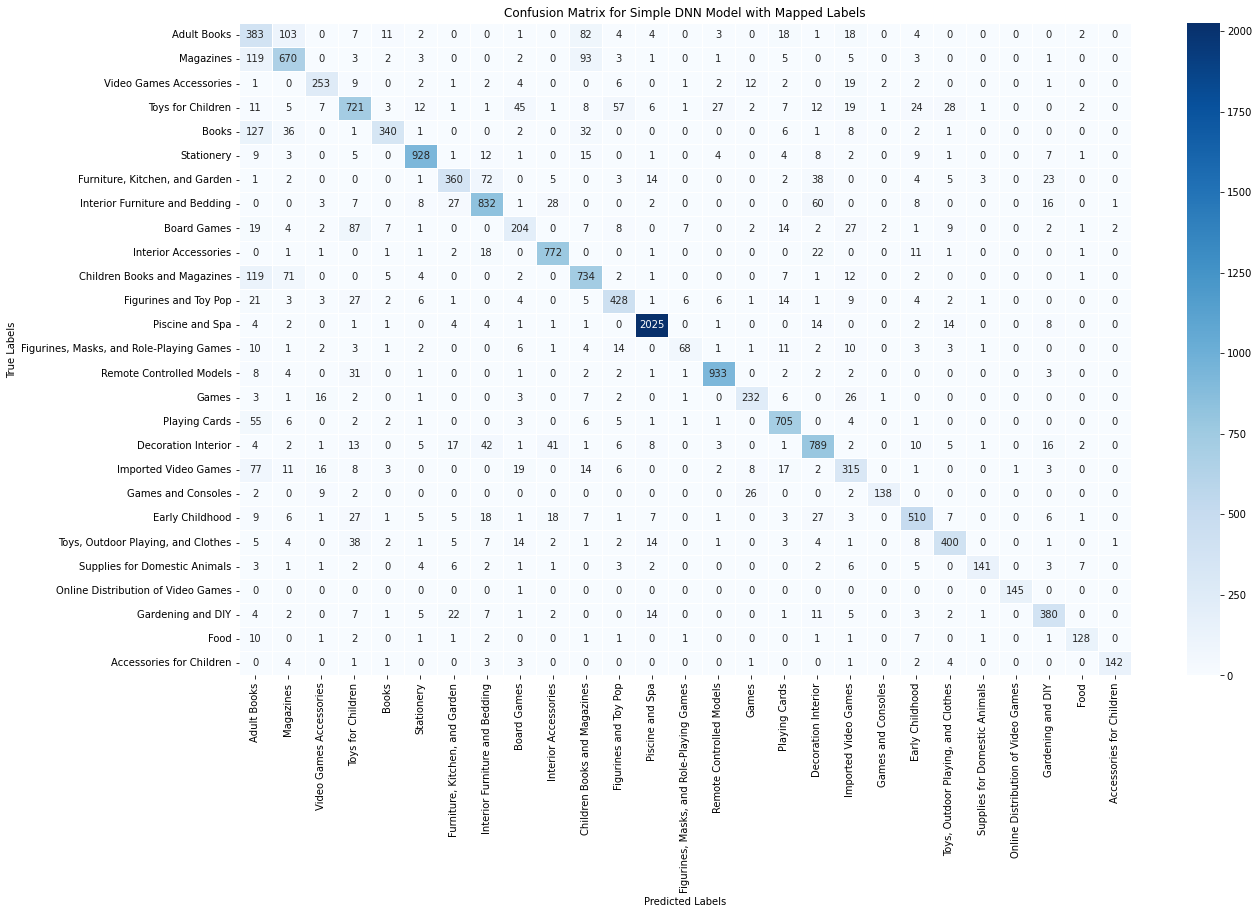

In [11]:
import importlib
importlib.reload(config)  # Reload config to ensure any updates are applied
import src.model_evaluation  # Initial import

importlib.reload(src.model_evaluation)  # Force reload the module
from src.model_evaluation import generate_confusion_matrix  

# Generate the confusion matrix with mapped labels
conf_matrix_df_labeled = generate_confusion_matrix(y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix_df_labeled, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Simple DNN Model with Mapped Labels")
plt.show()


### 5.3.2 Breakdown of Misclassifications  
→ **Analyze misclassification trends, identify the most frequently misclassified classes, and assess overall model performance.**  

In this section, we analyze the model’s misclassification patterns using a structured approach.  
We present four breakdowns to understand where the model struggles the most.  

#### **Columns in the Misclassification Table:**  
- **Encoded target** → The encoded numerical representation of each class.  
- **Original prdtypecode** → The original product category code.  
- **Class Label** → The human-readable label of the class.  
- **Samples** → The total number of instances for each class.  
- **Misclassified Count** → The number of misclassified samples for the class.  
- **Misclassification Rate (%)** → The percentage of misclassified samples within the class.  
- **Global Misclassification Rate (%)** → The percentage of misclassified samples relative to the total dataset.  

####  **Key Misclassification Perspectives**  

1. **Classes with the highest number of samples**  
   - Shows the most **frequent classes** in the dataset.  
   - Helps assess whether a class’s misclassification is due to **its high occurrence** or **its inherent difficulty**.  
   - Large classes can dominate misclassification counts even if their misclassification rate is low.  

2. **Classes with the highest number of misclassifications**  
   - Highlights the classes with the **largest absolute number of errors**.  
   - Useful for identifying which classes **contribute the most errors**, regardless of their misclassification rate.  
   - A class with many misclassifications may indicate **model weakness** or **data imbalance**.  

3. **Classes with the highest misclassification rate (%)**  
   - Identifies the classes where the model **struggles the most** proportionally.  
   - A high rate suggests **systematic confusion** in distinguishing this class from others.  
   - Small classes with a **high error rate** might require **better feature representation** or **more training data**.  

4. **Classes contributing the most to overall misclassification (%)**  
   - Measures **each class’s impact on total model errors**.  
   - A class with **many samples and a moderate error rate** can still contribute significantly to overall misclassification.  
   - Helps prioritize which classes should be improved to **reduce total model error** the most.  


By examining these four aspects, we gain insights into both **systematic classification errors** and **dataset imbalances** that could be influencing the model’s performance.  


In [12]:
import importlib

importlib.reload(config)
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)
from src.model_evaluation import analyze_and_display_misclassification

# Calculs déjà réalisés
misclassified_counts = conf_matrix_df_labeled.sum(axis=1) - np.diag(conf_matrix_df_labeled)
total_samples_per_class = conf_matrix_df_labeled.sum(axis=1)
misclassification_rates = round((misclassified_counts / total_samples_per_class) * 100, 2)

# [✔]Call the function with a custom number of rows to display
# You can set `display_rows` to control how many rows are shown in the notebook.
# By default, it displays 10 rows.
misclassification_analysis_df = analyze_and_display_misclassification(
    y_test, y_pred_classes, misclassified_counts, total_samples_per_class, misclassification_rates, display_rows=10
)


[✔] Misclassification analysis DataFrame created!

Top classes with the highest number of samples: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
12,12,2583,Piscine and Spa,2083,58,2.78,0.34
5,5,2522,Stationery,1011,83,8.21,0.49
3,3,1280,Toys for Children,1002,281,28.04,1.65
7,7,1560,Interior Furniture and Bedding,993,161,16.21,0.95
14,14,1300,Remote Controlled Models,993,60,6.04,0.35
17,17,2060,Decoration Interior,970,181,18.66,1.07
10,10,2403,Children Books and Magazines,961,227,23.62,1.34
1,1,2280,Magazines,911,241,26.45,1.42
9,9,1920,Interior Accessories,832,60,7.21,0.35
16,16,1160,Playing Cards,793,88,11.10,0.52



Top classes with the highest number of misclassifications: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,281,28.04,1.65
0,0,10,Adult Books,643,260,40.44,1.53
1,1,2280,Magazines,911,241,26.45,1.42
10,10,2403,Children Books and Magazines,961,227,23.62,1.34
4,4,2705,Books,557,217,38.96,1.28
8,8,1281,Board Games,408,204,50.00,1.20
18,18,40,Imported Video Games,503,188,37.38,1.11
17,17,2060,Decoration Interior,970,181,18.66,1.07
6,6,2582,"Furniture, Kitchen, and Garden",533,173,32.46,1.02
7,7,1560,Interior Furniture and Bedding,993,161,16.21,0.95



Top classes with the highest misclassification rate (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
13,13,1180,"Figurines, Masks, and Role-Playing Games",144,76,52.78,0.45
8,8,1281,Board Games,408,204,50.00,1.20
0,0,10,Adult Books,643,260,40.44,1.53
4,4,2705,Books,557,217,38.96,1.28
18,18,40,Imported Video Games,503,188,37.38,1.11
6,6,2582,"Furniture, Kitchen, and Garden",533,173,32.46,1.02
3,3,1280,Toys for Children,1002,281,28.04,1.65
1,1,2280,Magazines,911,241,26.45,1.42
22,22,2220,Supplies for Domestic Animals,190,49,25.79,0.29
10,10,2403,Children Books and Magazines,961,227,23.62,1.34



Top classes contributing the most to overall misclassification (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,281,28.04,1.65
0,0,10,Adult Books,643,260,40.44,1.53
1,1,2280,Magazines,911,241,26.45,1.42
10,10,2403,Children Books and Magazines,961,227,23.62,1.34
4,4,2705,Books,557,217,38.96,1.28
8,8,1281,Board Games,408,204,50.00,1.20
18,18,40,Imported Video Games,503,188,37.38,1.11
17,17,2060,Decoration Interior,970,181,18.66,1.07
6,6,2582,"Furniture, Kitchen, and Garden",533,173,32.46,1.02
7,7,1560,Interior Furniture and Bedding,993,161,16.21,0.95


### 5.3.3 Detailed Misclassification Statistics  
→ **Analyze individual misclassification cases, including total errors, misclassification rates, and overprediction trends.**  

####  Meaning of Columns in the Classification Error Analysis Table  

| **Column**                | **Description** |
|---------------------------|----------------|
| **True Label**            | The actual class of the sample in the test set (the correct category). |
| **Predicted Label**       | The incorrect class predicted by the model instead of the **True Label**. |
| **Count**                 | The number of times samples from **True Label** were misclassified as **Predicted Label**. |
| **Percentage**            | The proportion of this specific misclassification relative to **all misclassified instances**. Computed as: `(Count / Total Misclassified) * 100`. |
| **Class Sample Size** | The total number of test samples belonging to the **True Label** class (i.e., how many instances of this class exist in the test set). |
| **Misclassified Count**   | The total number of **True Label** samples that were misclassified (sum of all errors for this class). |
| **Misclassification Rate** | The error rate for the **True Label** class. Computed as: `(Misclassified Count /Class Sample Size) * 100`. |
| **Total Predicted**       | The total number of test samples predicted as belonging to the **Predicted Label** class (both correctly and incorrectly). |
| **Incorrect Predictions** | The number of test samples **incorrectly predicted** as **Predicted Label** (should have been a different class). |
| **Overprediction Rate**   | The proportion of incorrect predictions for the **Predicted Label** class. Computed as: `(Incorrect Predictions / Total Predicted) * 100`. |



In [13]:
importlib.reload(config) 
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)  # Force reload to use updated functions
from src.model_evaluation import generate_display_misclass_report

# Generate the enriched misclassification report
# NOTE: To display only a subset of rows, modify display_rows when calling the function
# Example: Use display_rows=20 to show only the top 20 rows:
misclassification_report = generate_display_misclass_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH, display_rows=20 # Set top_n to an integer (e.g., 20) to limit rows
)

# # Display the final enriched report
# print("\n[✔] Consolidated Misclassification Report:")
# display(misclassification_report)


Misclassification Report: (showing up to 20 rows)



,True Label,Predicted Label,Count,Percentage,Class Sample Size,Misclassified Count,Misclassification Rate,Total Predicted,Incorrect Predictions,Overprediction Rate
0,Books,Adult Books,127,3.84%,557,217,38.96%,1004,621,61.85%
1,Magazines,Adult Books,119,3.60%,911,241,26.45%,1004,621,61.85%
2,Children Books and Magazines,Adult Books,119,3.60%,961,227,23.62%,1004,621,61.85%
3,Adult Books,Magazines,103,3.11%,643,260,40.44%,942,272,28.87%
4,Magazines,Children Books and Magazines,93,2.81%,911,241,26.45%,1020,286,28.04%
5,Board Games,Toys for Children,87,2.63%,408,204,50.00%,1006,285,28.33%
6,Adult Books,Children Books and Magazines,82,2.48%,643,260,40.44%,1020,286,28.04%
7,Imported Video Games,Adult Books,77,2.33%,503,188,37.38%,1004,621,61.85%
8,"Furniture, Kitchen, and Garden",Interior Furniture and Bedding,72,2.18%,533,173,32.46%,1022,190,18.59%
9,Children Books and Magazines,Magazines,71,2.15%,961,227,23.62%,942,272,28.87%



[✔] Final Consolidated Report Generated!


### 5.4 **Exporting Classification Analysis to Excel** 

This step saves all classification insights into a **single Excel file** with multiple sheets for easy review.  

####  Exported Data Includes:
- **Well-Classified, Moderately Classified, Poorly Classified** categories (sorted by F1-score).  
- **Misclassification Analysis** (error rates, misclassified counts).  
- **Consolidated Misclassification Report** (detailed misclassification breakdown per class).  
- **Raw Confusion Matrix** (numerical values without labels).  

####  Output File Example:  
**`classification_analysis_<MODEL_NAME>_<TIMESTAMP>.xlsx`**  



In [14]:
import importlib
import src.model_evaluation  # Initial import
import src.export_utils  # # Initial import

importlib.reload(config) # Force reload module
importlib.reload(src.model_evaluation)  # Force reload module
importlib.reload(src.export_utils)  # Force reload module

from src.model_evaluation import analyze_and_display_misclassification, generate_display_misclass_report
from src.export_utils import export_all_analysis




# Define model name and file prefix
model_used = "Simple_DNN_Model"
file_prefix = "classification_analysis"

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Convert conf_matrix_df_raw to Pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_df_raw, 
                              index=[f"True Class {label}" for label in set(y_test)],  # Index as True Labels
                              columns=[f"Pred Class {label}" for label in set(y_pred_classes)])  # Columns as Predicted Labels



# Generates and displays misclassification analysis
full_misclassification_analysis_df = analyze_and_display_misclassification(y_test,
                                                                           y_pred_classes,
                                                                           misclassified_counts,
                                                                           total_samples_per_class,
                                                                           misclassification_rates,
                                                                           display_rows=None,
                                                                           display_output=False
)

#Generates and displays a comprehensive misclassification report combining multiple analyses
full_misclassification_report = generate_display_misclass_report(y_test,
                                                                 y_pred_classes,
                                                                 config.PRDTYPECODE_MAPPING_PATH,
                                                                 display_rows=None,
                                                                display_output=False
)



dataframes_to_export = {
    "Class Categorization": {
        f"Well-Classified (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})": well_classified.sort_values(by="f1-score", ascending=False),
        f"Moderately Classified ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})": moderately_classified.sort_values(by="f1-score", ascending=False),
        f"Poorly Classified (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})": poorly_classified.sort_values(by="f1-score", ascending=True),
    },
    "Misclassification Analysis": full_misclassification_analysis_df,
    "Consolidated Misclassification Report": full_misclassification_report,
    "Raw Confusion Matrix": conf_matrix_df
}

# Export all the data
export_path = export_all_analysis(
    dataframes_dict=dataframes_to_export,
    model_name=model_used,
    file_prefix=file_prefix,
    mode="text",
    classification_df=classification_df,
    summary_rows=summary_rows,
    accuracy_value=accuracy_value,
    accuracy_support=accuracy_support
)

# Print confirmation
print(f"\n[✔] Full classification analysis saved to: {export_path}")

[✔] Misclassification analysis DataFrame created!

[✔] Final Consolidated Report Generated!

[✔] Full classification analysis saved to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\reports\classification_reports\text\classification_analysis_Simple_DNN_Model_2025-02-25_15-19-51.xlsx


## 6. Hyperparameter Tuning 
Fine-tuning the model by testing multiple hyperparameter configurations to optimize performance.

### 6.1 Hyperparameter Search for LSTM Model using RandomizedSearchCV

In [ ]:
# %%time

# from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier  
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# import numpy as np

# # Function to create the model (needed for KerasClassifier)
# def create_model(optimizer='adam', gru_units=128, dropout_rate=0.3, learning_rate=0.001):
#     model = Sequential()
#     model.add(Embedding(10000, 200))  # Embedding layer
#     model.add(RNN(GRUCell(gru_units), return_sequences=True))  # GRU Layer
#     model.add(Dropout(dropout_rate))  # Dropout layer
#     model.add(GlobalAveragePooling1D())  # Global Average Pooling
#     model.add(Dense(256, activation='relu'))  # Dense Layer
#     model.add(Dropout(dropout_rate))  # Dropout layer
#     model.add(Dense(27, activation='softmax'))  # Output Layer
    
#     # Choose the optimizer based on the input
#     if optimizer == 'adam':
#         optimizer = Adam(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         optimizer = RMSprop(learning_rate=learning_rate)
#     elif optimizer == 'sgd':
#         optimizer = SGD(learning_rate=learning_rate)

#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Wrap the Keras model with Sci-Keras KerasClassifier
# model = KerasClassifier(model=create_model, verbose=0)

# # Hyperparameter grid to search
# param_dist = {
#     'optimizer': ['adam', 'rmsprop', 'sgd'],
#     'gru_units': [64, 128, 256],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'learning_rate': [0.0001, 0.001, 0.01],
#     'batch_size': [32, 64, 128],
#     'epochs': [5, 10, 15]  # Tuning number of epochs
# }

# # Use RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=10, 
#     cv=3, 
#     verbose=2, 
#     n_jobs=-1
# )

# # Fit the RandomizedSearchCV on the training data
# random_search.fit(X_train, y_train.values)

# # Print the best hyperparameters found
# print(f"Best Hyperparameters: {random_search.best_params_}")


### 6.2 Retraining LSTM Model with Best Hyperparametersers

In [ ]:
# # Get the best hyperparameters found by RandomizedSearchCV
# best_params = random_search.best_params_

# # Create a new model using the best hyperparameters
# best_model = create_model(
#     optimizer=best_params['optimizer'], 
#     gru_units=best_params['gru_units'],
#     dropout_rate=best_params['dropout_rate'], 
#     learning_rate=best_params['learning_rate']
# )

# # Retrain the model with the best hyperparameters
# history = best_model.fit(
#     X_train, 
#     y_train.values, 
#     batch_size=best_params['batch_size'], 
#     epochs=best_params['epochs'], 
#     validation_data=(X_test, y_test.values)
# )

# # Print the best hyperparameters used to retrain the model
# print(f"Retrained model with best hyperparameters: {best_params}")

 ### 6.3 Evaluating the Best Model Performance

In [ ]:
# # ==========================================================================================
# # Evaluate the Best Model Performance
# # ==========================================================================================

# # Make predictions on the test set
# y_pred_best = best_model.predict(X_test)
# y_pred_best = y_pred_best.argmax(axis=1)  # Convert one-hot or probability outputs to class labels if necessary

# # Compute evaluation metrics
# accuracy = accuracy_score(y_test, y_pred_best)
# weighted_f1 = f1_score(y_test, y_pred_best, average="weighted")

# # Print classification report
# print(f"[✔] Accuracy: {accuracy:.4f}")
# print(f"[✔] Weighted F1-Score: {weighted_f1:.4f}\n")
# print("Classification Report:\n", classification_report(y_test, y_pred_best))

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_best)

# # Plot the confusion matrix
# plt.figure(figsize=(18, 12))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(27), yticklabels=range(27))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for the Best GRU Cell Model")
# plt.show()


## 7. Conclusion